In [1]:
import numpy as np
import h5py

from matplotlib import rc
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# #                                                                                                                                       
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})                                                                                             
mpl.rcParams['text.usetex'] = False
mpl.rcParams.update({'xtick.labelsize': 18})
mpl.rcParams.update({'ytick.labelsize': 18})
mpl.rcParams.update({'axes.labelsize': 18})
mpl.rcParams.update({'legend.frameon': False})
mpl.rcParams.update({'lines.linewidth': 2})

import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS)
hep.style.use("CMS")

from matplotlib.lines import Line2D

/tmp/ipykernel_1487185/4250593878.py:26: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [8]:
# get 2004 aleph measurement
with open("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/HEPData-ins636645-v1-Table_54.csv", 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

aleph_bins = 1 - np.append(1.0, hepdata[::-1,1])
aleph_midbins = (aleph_bins[1:] + aleph_bins[:-1])/2
aleph_thrust = hepdata[::-1,3]
aleph_thrust_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
assert np.all(aleph_bins[1:] == 1 - hepdata[::-1,1]) and np.all(aleph_bins[:-1] == 1 - hepdata[::-1,2])

aleph_log_bins = np.log(aleph_bins + np.exp(-8))
aleph_log_midbins = (aleph_log_bins[1:] + aleph_log_bins[:-1])/2
log_binwidths = aleph_log_bins[1:] - aleph_log_bins[:-1]
aleph_log_thrust = aleph_thrust * 0.01 / log_binwidths
aleph_log_thrust_errs = aleph_thrust_errs * 0.01 / log_binwidths

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [9]:
# data raw
data = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/data_vals_reco.npy")
dpass = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/data_pass_reco.npy").astype(bool)

# pythia 6 gen
gen = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/MC_vals_truth.npy")
gpass = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/MC_pass_truth.npy").astype(bool)

# pythia 6 reco
reco = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/MC_vals_reco.npy")
rpass = np.load("/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/MC_pass_reco.npy").astype(bool)

In [10]:
# unfolded results
# steps:
# 1. save all model evaluation weights rather than the finished histogram
# 2. histogram in here all distributions using the correct binning
# 3. plot nominal value
# 4. compute error bars
# 5. plot error bars

bootstrap_sim_full  = "/global/u1/b/badea/OmniFold/eval/boot_sim_n_40/" # bootstrap sim full n=40
bootstrap_data_full = "/global/u1/b/badea/OmniFold/eval/phys_weights_n_40/" # bootstrap data full n=40
ensemble = "/global/u1/b/badea/OmniFold/eval/redone_enemble_weights" # ensemble 40

x = h5py.File("../eval/phys_weights_n_40/bootstrap_n_1/22062023_07:54:41_gpu_2_1.h5","r")
bin_edges = np.array(x['bins'])
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
unfolded_logmid = np.log(midpoints)
unfolded_counts = np.array(x['counts'])

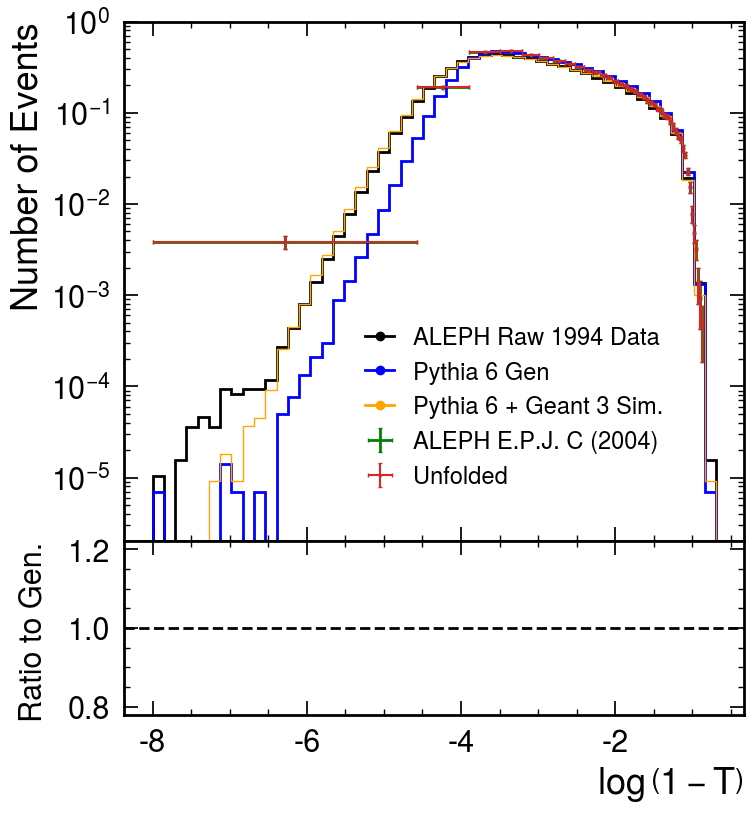

In [11]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,9))
plt.subplots_adjust(hspace=0)

bins =  np.linspace(-8, np.log(0.5), 50+1)
density = True

# ALEPH 2004 measurement
ax1.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH E.P.J. C (2004)', 
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
ax1.hist(np.log(1-data[dpass]), bins=bins, color='black', label='ALEPH Raw 1994 Data', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Gen
ax1.hist(np.log(1-gen[gpass]), bins=bins, color='blue', label='Pythia 6 Gen', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Reco
ax1.hist(np.log(1-reco[rpass]), bins=bins, color='orange', label='Pythia 6 + Geant 3 Sim.', histtype = 'step', density=density)

# unfolded distribution
ax1.errorbar(aleph_log_midbins, aleph_log_thrust, color='tab:red', label='Unfolded', 
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, fmt='o', lw=1.5, capsize=1.5, capthick=1, markersize=1.5)

ax1.legend()

# Bottom subplot (ratio plot)
ax2.axhline(y=1, color='black', linestyle='--')  # Adding a horizontal line at y=1 for reference

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 22,
                     "pad"       : 10}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18}
ax1.tick_params(**tick_params_major)
ax1.tick_params(**tick_params_minor)
ax2.tick_params(**tick_params_major)
ax2.tick_params(**tick_params_minor)

# set limits
ax1.set_ylim(0.2*10**-5, 10**0)
# ax2.set_xlim(-10,0)
ax2.set_ylim(0.78,1.22)

# log scale
ax1.set_yscale("log")

# axis labels
ax1.set_ylabel("Number of Events") #r'Number of $\tilde{\eta}$ decays/Event')
ax2.set_ylabel("Ratio to Gen.", fontsize=22, labelpad=14)
ax2.set_xlabel(r'$\log\left(1-T\right)$')

# legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
for h in handles:
    try:
        new_handles.append(Line2D([], [], linestyle='-', marker='o', c=h.get_edgecolor()))
    except:
        new_handles.append(h)
            
ax1.legend(new_handles,
          labels,
          title="",
          title_fontsize="13",
          ncol=1,
          framealpha=0.0,
          prop={'size': 17},
          bbox_to_anchor=(0.35, 0.01, 0.45, 0.45), #(0.54, 0.45, 0.45, 0.5)
          handlelength=1.25)

# add text
# left, top, t = 0.07, 0.94, 0.06
# stamps = [
#     r"higgs portal, $pp \rightarrow h \rightarrow q_{d}q_{d} \; (q_{d} \rightarrow (dark) \; hadrons)$",
#     "arxiv:2103.01238",
#     r"$\mathit{m_{\tilde{\omega}}} = \mathit{m_{\tilde{\eta}}}$",
#     r"$c\tau = 30\; mm \times \left(\frac{5 \; GeV}{\mathit{m_{\tilde{\eta}}}}\right)^{7}$", #  # 5 \; GeV / \mathit{m_{\tilde{\eta}}}
#     r"$L_{xy} < 1000\; mm$",
#     r"$\mathrm{p_{T}}$ > 5 GeV, |$\eta$|<2.4",
# ]
# for i, stamp in enumerate(stamps):
#     ax1.text(left, top - i*t, stamp, fontsize=14, ha='left', va='top', transform=ax1.transAxes)

# save
# plt.savefig("number_of_decays.pdf", bbox_inches="tight")